In [1]:
import os
import pandas as pd
from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets import splits
import torchvision.transforms as T
import timm
from wildlife_tools.features import *
from wildlife_tools.data import ImageDataset
from wildlife_tools.similarity import CosineSimilarity, MatchLOFTR, MatchLightGlue
from wildlife_tools.similarity.wildfusion import SimilarityPipeline, WildFusion
from wildlife_tools.similarity.calibration import IsotonicCalibration
import numpy as np
from wildlife_tools.inference import KnnClassifier
import matplotlib.pyplot as plt
from PIL import Image  
import pickle
import yaml

In [32]:
# --- Load Configuration ---
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [33]:
DATA_ROOT = os.path.expanduser(config['paths']['data_root'])
IMAGE_DIR = config['paths']['dataset_dir'].format(data_root=DATA_ROOT)
MANIFEST_FILE = config['paths']['merged_manifest_file'].format(data_root=DATA_ROOT)
CALIBRATION_DIR = config['paths']['calibration_dir'].format(data_root=DATA_ROOT)
PREDICTIONS_FILE = config['paths']['predictions_file'].format(data_root=DATA_ROOT)

In [4]:
class Horses(datasets.WildlifeDataset):
    def create_catalogue(self) -> pd.DataFrame:
        """Create catalogue from manifest file"""
        # Read the manifest file
        manifest_df = pd.read_csv(MANIFEST_FILE)
        
        rows = []
        # Process each entry in the manifest
        for _, row in manifest_df.iterrows():
            # Skip if status is EXCLUDE or num_horses_detected is NONE or MULTIPLE
            if 'status' in row and row['status'] == 'EXCLUDE':
                continue
            if 'num_horses_detected' in row and row['num_horses_detected'] in ['NONE', 'MULTIPLE']:
                continue
            # Create a catalogue entry
            rows.append({
                'image_id': row['filename'],
                'identity': row['canonical_id'],
                'horse_name': row['horse_name'],
                'path': row['filename'],
                'date': pd.to_datetime(str(row['email_date']), format='%Y%m%d')  # Convert to datetime
            })
        
        # Create DataFrame from collected rows
        df = pd.DataFrame(rows)
        result = self.finalize_catalogue(df)
        return result

In [5]:
horses = Horses(IMAGE_DIR)
horses_df = horses.create_catalogue()

Number of identitites            168
Number of all animals            1268
Number of animals with one image 3
Number of unidentified animals   0
Images span                      2.6 years


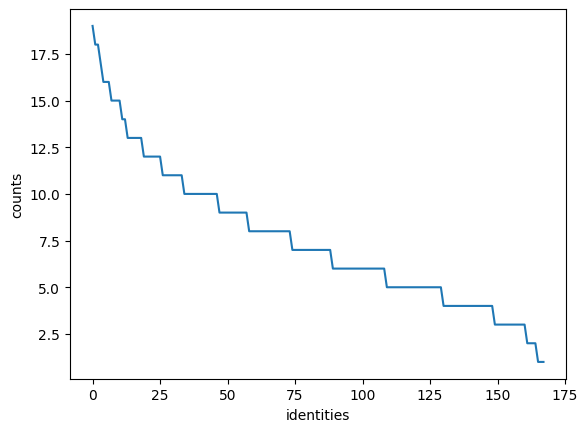

In [6]:
display_statistics(horses_df)

Figure(640x480)


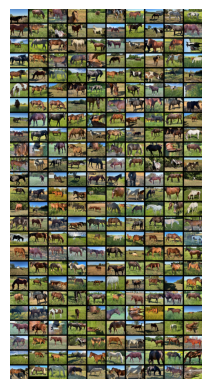

In [7]:
print(horses.plot_grid(n_rows=25, n_cols=10))

split the catalog into *training* and *testing* sets

In [8]:
splitter = splits.DisjointSetSplit(n_class_test=75)
for idx_train, idx_test in splitter.split(horses_df):
    splits.analyze_split(horses_df, idx_train, idx_test)

df_train = horses_df.loc[idx_train]
df_test = horses_df.loc[idx_test]

dataset_train = ImageDataset(df_train, horses.root)

Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 673/595/0/1268
Classes: train/test/unassigned/total = 93/75/0/168
Samples: train only/test only        = 673/595
Classes: train only/test only/joint  = 93/75/0

Fraction of train set     = 53.08%
Fraction of test set only = 46.92%


# Training

In [9]:
matchers = {

    'lightglue_superpoint': SimilarityPipeline(
        matcher = MatchLightGlue(features='superpoint'),
        extractor = SuperPointExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_aliked': SimilarityPipeline(
        matcher = MatchLightGlue(features='aliked'),
        extractor = AlikedExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_disk': SimilarityPipeline(
        matcher = MatchLightGlue(features='disk'),
        extractor = DiskExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_sift': SimilarityPipeline(
        matcher = MatchLightGlue(features='sift'),
        extractor = SiftExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    # SimilarityPipeline(
    #     matcher = MatchLOFTR(pretrained='outdoor'),
    #     extractor = None,
    #     transform = T.Compose([
    #         T.Resize([512, 512]),
    #         T.Grayscale(),
    #         T.ToTensor(),
    #     ]),
    #     calibration = IsotonicCalibration()
    # ),

    # 'wildlife-mega-L-384': SimilarityPipeline(
    #     matcher = CosineSimilarity(),
    #     extractor = DeepFeatures(
    #         model = timm.create_model(
    #           'hf-hub:BVRA/wildlife-mega-L-384',
    #           num_classes=0,
    #           pretrained=True
    #           )
    #     ),
    #     transform = T.Compose([
    #         T.Resize(size=(384, 384)),
    #         T.ToTensor(),
    #         T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #     ]),
    #     calibration = IsotonicCalibration()
    # ),
}

priority_matcher =  SimilarityPipeline(
    matcher = CosineSimilarity(),
    extractor = DeepFeatures(
        model = timm.create_model(
        'hf-hub:BVRA/wildlife-mega-L-384',
        num_classes=0,
        pretrained=True
        )
    ),
    transform = T.Compose([
        T.Resize(size=(384, 384)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]),
)




/Users/dleigh/git/dlleigh/horse-id/.venv/lib/python3.13/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [10]:
# Create calibration directory if it doesn't exist
os.makedirs(CALIBRATION_DIR, exist_ok=True)

# Check for existing calibrations and load them
print("Checking for existing calibrations...")
all_loaded = True
for name, matcher in matchers.items():
    cal_file = f"{CALIBRATION_DIR}/{name}.pkl"
    if os.path.exists(cal_file):
        print(f"Loading calibration: {cal_file}")
        try:
            with open(cal_file, 'rb') as f:
                matcher.calibration = pickle.load(f)
                matcher.calibration_done = True  # Set the flag after successful load
        except Exception as e:
            print(f"Error loading calibration {cal_file}: {e}")
            all_loaded = False
    else:
        print(f"Missing calibration: {cal_file}")
        all_loaded = False

wildfusion = WildFusion(calibrated_pipelines = list(matchers.values()), priority_pipeline= priority_matcher)

if not all_loaded:
    print("\nFitting new calibrations...")
    wildfusion.fit_calibration(dataset_train, dataset_train)
    
    # Save calibrations
    print("\nSaving calibrations...")
    for name, matcher in matchers.items():
        cal_file = f"{CALIBRATION_DIR}/{name}.pkl"
        try:
            with open(cal_file, 'wb') as f:
                pickle.dump(matcher.calibration, f)
            print(f"Saved: {cal_file}")
        except Exception as e:
            print(f"Error saving calibration {cal_file}: {e}")
else:
    print("\nAll calibrations loaded successfully")

Checking for existing calibrations...
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_superpoint.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_aliked.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_disk.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_sift.pkl

All calibrations loaded successfully


# Testing

Split the testing dataset into *query* and *database* sets

In [11]:
splitter = splits.ClosedSetSplit(0.2)
for idx_query, idx_database in splitter.split(df_test):
    splits.analyze_split(df_test, idx_query, idx_database)
    
df_query = df_test.loc[idx_query]
df_database = df_test.loc[idx_database]

dataset_query = ImageDataset(df_query, horses.root)
dataset_database = ImageDataset(df_database, horses.root)

Split: time-unaware closed-set
Samples: train/test/unassigned/total = 122/473/0/595
Classes: train/test/unassigned/total = 75/75/0/75
Samples: train only/test only        = 0/0
Classes: train only/test only/joint  = 0/0/75

Fraction of train set     = 20.50%
Fraction of test set only = 0.00%


In [12]:
similarity = wildfusion(dataset_query, dataset_database, B=10)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.82s/it]


## Evaluate

In [13]:
classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
predictions = classifier(similarity)
accuracy = np.mean(dataset_query.labels_string == predictions)

In [14]:
accuracy

np.float64(0.9016393442622951)

## Create visualization

In [44]:
# Ensure horses_root is an absolute path for reliable linking in the HTML
horses_root_abs = os.path.abspath(IMAGE_DIR)

html_parts = ["""
<!DOCTYPE html>
<html>
<head>
    <title>Prediction Results (Linked Images)</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; background-color: #f4f4f4; }
        h1 { text-align: center; color: #333; }
        .prediction-grid { display: flex; flex-direction: column; align-items: center; }
        .prediction-pair {
            display: flex;
            justify-content: space-around;
            align-items: flex-start; /* Align items to the top */
            border: 3px solid #ccc;
            margin-bottom: 20px;
            padding: 15px;
            background-color: #fff;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            width: 90%;
            max-width: 1000px; /* Max width for a pair */
        }
        .image-container {
            flex: 1;
            padding: 10px;
            text-align: center;
            max-width: 48%; /* Ensure images don't get too large */
        }
        .image-container img {
            max-width: 100%;
            height: auto; /* Maintain aspect ratio */
            max-height: 400px; /* Optional: constrain max height */
            border: 1px solid #ddd;
            margin-top: 5px;
        }
        .image-container p {
            font-size: 0.9em;
            color: #555;
            margin-bottom: 5px;
            word-wrap: break-word; /* Prevent long names from breaking layout */
        }
        .correct { border-color: green; }
        .incorrect { border-color: red; }
    </style>
</head>
<body>
    <h1>Horse ID Prediction Results (Linked Images)</h1>
    <div class="prediction-grid">
"""]

for idx in range(len(predictions)):
    current_test_row = df_query.iloc[idx]
    test_path_rel = current_test_row['path']
    # Construct absolute path for the image src attribute
    test_path_abs_for_html = "file://" + os.path.join(horses_root_abs, test_path_rel)
    # Absolute path for checking file existence
    test_path_abs_for_check = os.path.join(horses_root_abs, test_path_rel)

    actual_horse_id = current_test_row['identity']
    test_name = current_test_row['horse_name']
    
    pred_horse_id_classifier = int(str(predictions[idx]))

    pred_path_abs_for_html = None
    pred_path_rel_for_display = "N/A"
    pred_name_specific_match = "N/A"
    pred_id_specific_match = "N/A"
    title_pred_name_classifier = "N/A"

    if idx < similarity.shape[0]:
        idx_in_database_df = np.argmax(similarity[idx, :])
        if idx_in_database_df < len(df_database):
            matched_db_image_row = df_database.iloc[idx_in_database_df]
            pred_path_rel_for_display = matched_db_image_row['path']
            pred_path_abs_for_html = "file://" + os.path.join(horses_root_abs, pred_path_rel_for_display)
            pred_path_abs_for_check_pred = os.path.join(horses_root_abs, pred_path_rel_for_display)
            
            pred_name_specific_match = matched_db_image_row['horse_name']
            pred_id_specific_match = matched_db_image_row['identity']
    
    predicted_horse_name_for_title_df = df_database[df_database['identity'] == pred_horse_id_classifier]
    if not predicted_horse_name_for_title_df.empty:
        title_pred_name_classifier = predicted_horse_name_for_title_df.iloc[0]['horse_name']

    border_class = 'correct' if actual_horse_id == pred_horse_id_classifier else 'incorrect'

    html_parts.append(f'<div class="prediction-pair {border_class}">')
    html_parts.append('  <div class="image-container">')
    html_parts.append(f'    <p><b>Test Image</b><br>Actual: {test_name} (ID: {actual_horse_id})</p>')
    if os.path.exists(test_path_abs_for_check):
        html_parts.append(f'    <img src="{test_path_abs_for_html}" alt="Test Image: {test_name}">')
    else:
        html_parts.append(f'    <p style="color:red;">Test image not found: {test_path_abs_for_html}</p>')
    html_parts.append('  </div>')

    html_parts.append('  <div class="image-container">')
    title_text = f'<b>Predicted Match</b>  Similarity: {similarity[idx, idx_in_database_df]:.2f}<br>Predicted ID: {title_pred_name_classifier} ({pred_horse_id_classifier})'
    html_parts.append(f'    <p>{title_text}</p>')

    if pred_path_abs_for_html and os.path.exists(pred_path_abs_for_check_pred):
        html_parts.append(f'    <img src="{pred_path_abs_for_html}" alt="Predicted Match: {pred_name_specific_match}">')
    else:
        html_parts.append(f'    <p style="color:red;">Predicted image not found or path error: {pred_path_abs_for_html or "N/A"}</p>')
    html_parts.append('  </div>')
    html_parts.append('</div>')

html_parts.append("""
    </div>
</body>
</html>
""")

final_html = "\n".join(html_parts)
with open(PREDICTIONS_FILE, 'w', encoding='utf-8') as f:
    f.write(final_html)
print(f"Linked HTML prediction results saved to: {PREDICTIONS_FILE}")

Linked HTML prediction results saved to: /Users/dleigh/google-drive/horseID Project/data/prediction_results.html
